In [1039]:
import scanpy as sc
import pandas as pd 
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import warnings
import itertools as it
import pickle as pkl
import os
from copy import copy
import warnings
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import seaborn as sns

In [2]:
sc.settings.verbosity = 4
sc.settings.set_figure_params(dpi=80)

In [3]:
prefix = '/data/xyzeq/'

# Load in the Datasets

### Load in the 10x data

In [769]:
warnings.filterwarnings('ignore')
liver1 = sc.read_10x_h5(prefix + '10x/20191102/Liver1_raw_feature_bc_matrix.h5', genome='mm10')
sc.utils.view_to_actual(liver1)
liver1.var_names_make_unique()
warnings.filterwarnings('default')

reading /data/xyzeq/10x/20191102/Liver1_raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:07)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Visualize the knee plot to draw a cutoff for the 10x cells. There was high background in this data.

In [770]:
sc.pp.filter_cells(liver1, min_counts=0)

In [771]:
vals = liver1.obs['n_counts'].sort_values(ascending=False).values

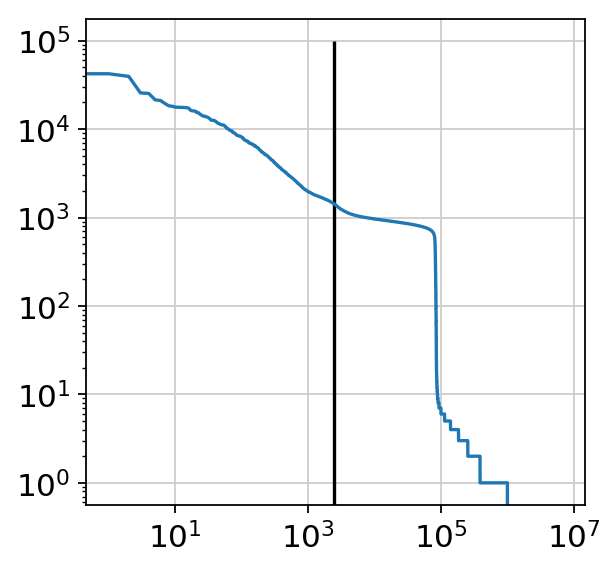

In [772]:
plt.plot(vals)
plt.xscale('log')
plt.yscale('log')
plt.vlines(2500, 0, 1e5);

In [773]:
cell_number = 2500
liver1 = liver1[liver1.obs['n_counts'].sort_values(ascending=False)[:cell_number].index.values,:].copy()

Threshold %mito.

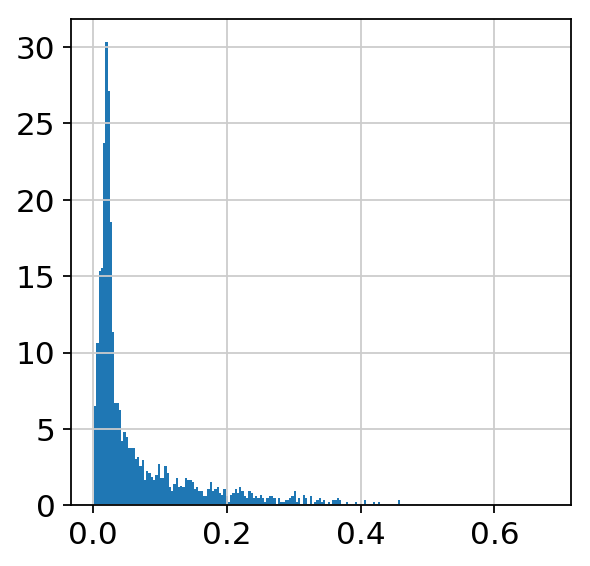

In [774]:
genelist = liver1.var_names.tolist()

mito_genes_names = [gn for gn in genelist if gn.startswith('mt-')]
mito_genes = [genelist.index(gn) for gn in mito_genes_names]

liver1.obs['percent_mito'] = np.ravel(np.sum(liver1[:, mito_genes].X, axis=1)) / np.ravel(np.sum(liver1.X, axis=1))

plt.hist(liver1.obs['percent_mito'].values,bins=200,density=True);

In [775]:
liver1 = liver1[liver1.obs['percent_mito'] < 0.1].copy()

In [776]:
liver1.shape

(1949, 28692)

### Dimensionality Reduction and Clustering

In [777]:
sc.pp.log1p(liver1)
sc.pp.normalize_per_cell(liver1, counts_per_cell_after=1e6)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [778]:
liver1_unscaled = liver1.copy()

In [779]:
sc.pp.scale(liver1)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 100
    finished (0:00:03)


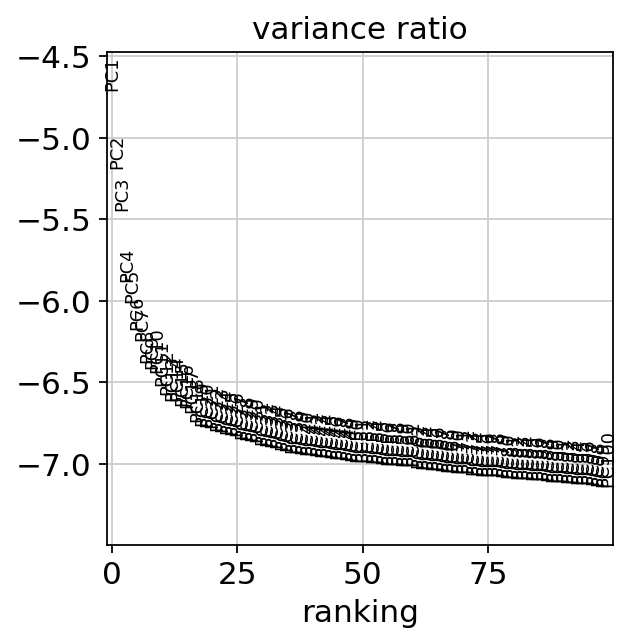

In [780]:
warnings.filterwarnings('ignore')
sc.pp.pca(liver1,n_comps=100)
sc.pl.pca_variance_ratio(liver1,log=True, n_pcs=100)
warnings.filterwarnings('default')

In [781]:
warnings.filterwarnings('ignore')
sc.pp.neighbors(liver1,n_neighbors=15,n_pcs=35) # using all available embeddings, numba warning outlined here is not to be of concern: https://github.com/lmcinnes/umap/issues/252
warnings.filterwarnings('default')

computing neighbors
    using 'X_pca' with n_pcs = 35
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)


In [782]:
sc.tl.umap(liver1)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:04)


In [783]:
sc.tl.leiden(liver1,resolution=1)

running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


... storing 'feature_types' as categorical
... storing 'genome' as categorical


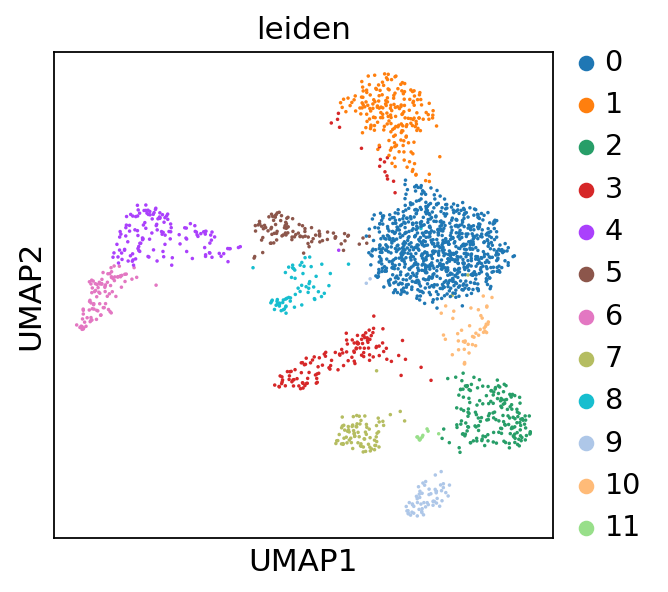

In [784]:
sc.pl.umap(liver1,color=['leiden'], size=10)

### Annotation

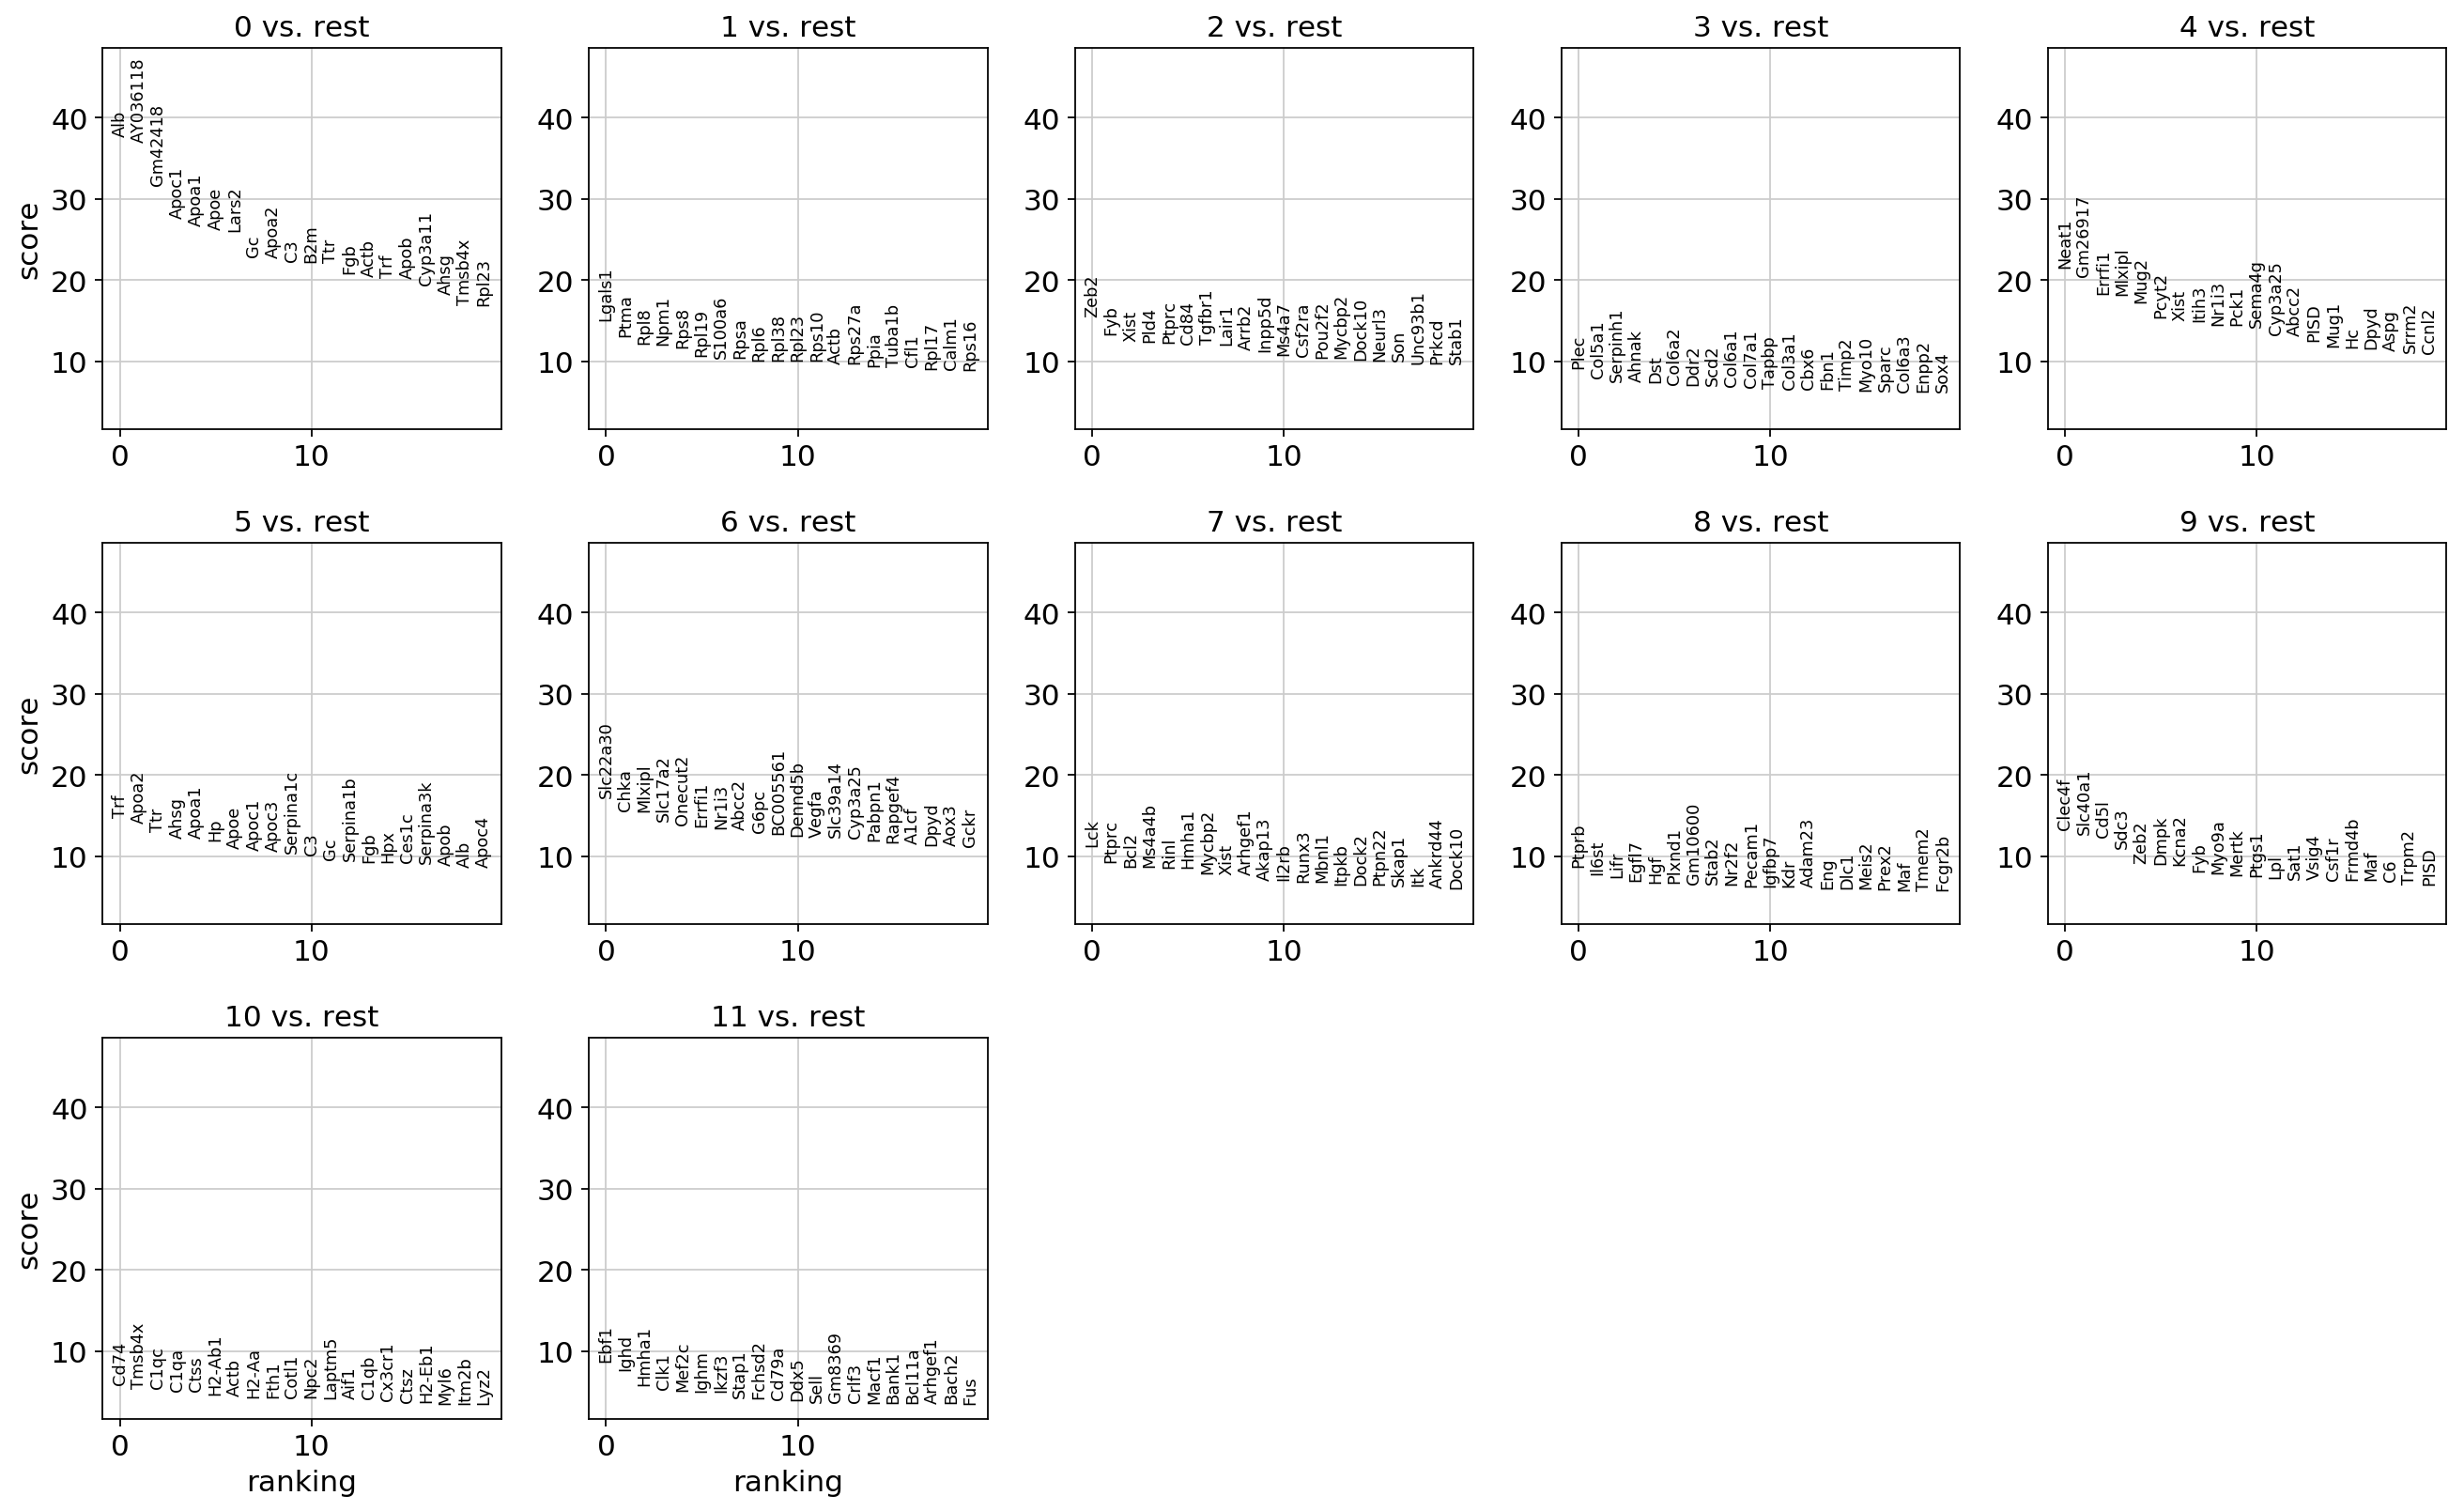

In [785]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(liver1, groupby='leiden', n_genes=200)
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(liver1, ncols=5)
sc.settings.verbosity = 3

In [786]:
# # Use this to print all the top genes
# for i in range(12):
#     print(i)
#     for j in liver1.uns['rank_genes_groups']['names'][str(i)][:25]:
#         print(j)
#     print('')
#     print('')

In [787]:
ctdict = dict()
ctdict['Hepatocyte (Cholesterol+)'] = [0]
ctdict['Galectin/Ribosomal/Cytoskeleton'] = [1]
ctdict['Myeloid 1 (Macrophage)'] = [2]
ctdict['Fibroblast/ECM'] = [3]
ctdict['Hepatocyte (Glycolyisis/PE)'] = [4]
ctdict['Hepatocyte (Cholesterol++)'] = [5]
ctdict['Hepatocyte (Lipid)'] = [6]
ctdict['Cytotoxic Lymphocyte'] = [7]
ctdict['LSEC'] = [8]
ctdict['Kupffer'] = [9]
ctdict['Myeloid 2 (DC/Microglia-like)'] = [10]
ctdict['B cell'] = [11]


liver1.obs['celltype'] = liver1.obs['leiden']
for ct in ctdict:
    for clust in ctdict[ct]:
        liver1.obs['celltype'].replace(r'^%s$' % str(clust), ct, regex=True, inplace=True)
liver1.obs['celltype'] = liver1.obs['celltype'].astype('category')

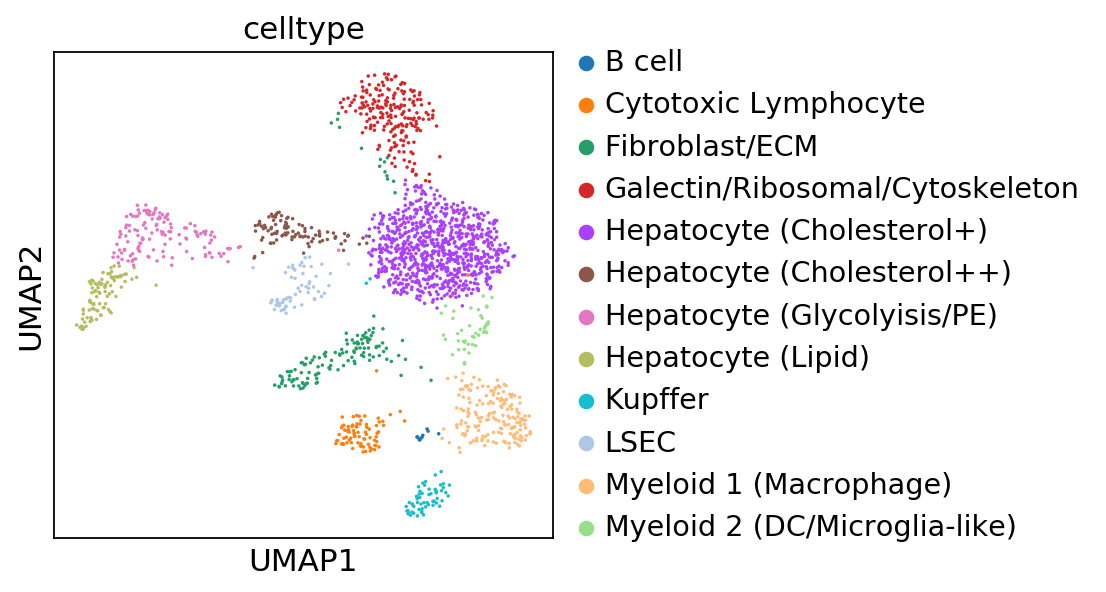

In [788]:
sc.pl.umap(liver1,color=['celltype'], size=10)

### Load in the XYZeq data

In [852]:
l20c1_path = prefix + 'xyzeq/individual.raw.and.proc.h5ads/20190920/20190920_L20C1.h5ad'
l20c1 = sc.read_h5ad(l20c1_path)

In [853]:
l20c1_h = l20c1[:,[i for i in l20c1.var_names if i.startswith('hg19_')]].copy()

In [854]:
sc.pp.filter_cells(l20c1_h, min_counts=0)

In [855]:
vals_h = l20c1_h.obs['n_counts'].sort_values(ascending=False).values

In [856]:
cell_number = 3000

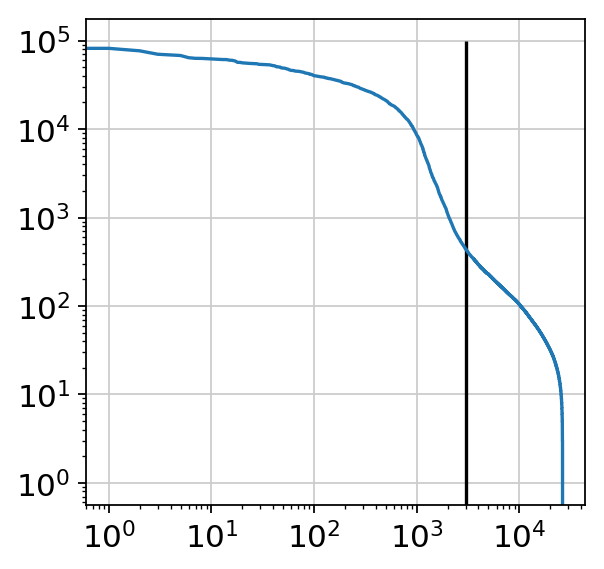

In [857]:
plt.plot(vals_h)
plt.xscale('log')
plt.yscale('log')
plt.vlines(cell_number, 0, 1e5);

In [795]:
human_cells = l20c1_h.obs['n_counts'].sort_values(ascending=False)[:cell_number].index.values
mouse_cells = np.setdiff1d(l20c1.obs_names.values, human_cells, True)

In [796]:
l20c1_h = l20c1_h[human_cells,:].copy()
l20c1_m = l20c1[mouse_cells,:].copy()

In [797]:
l20c1_m = l20c1_m[:,[i for i in l20c1_m.var_names if i.startswith('mm10_')]].copy()

In [798]:
l20c1_m.var_names = [i[5:] for i in l20c1_m.var_names]

In [799]:
sc.pp.filter_cells(l20c1_m, min_counts=0)

In [800]:
vals_m = l20c1_m.obs['n_counts'].sort_values(ascending=False).values

In [801]:
cell_number = 4000

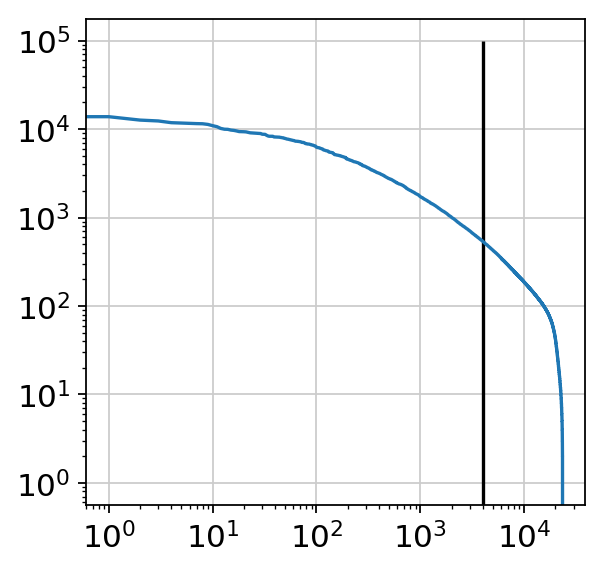

In [802]:
plt.plot(vals_m)
plt.xscale('log')
plt.yscale('log')
plt.vlines(cell_number, 0, 1e5);

In [803]:
l20c1_m = l20c1_m[l20c1_m.obs['n_counts'].sort_values(ascending=False)[:cell_number].index.values,:].copy()

Threshold %mito.

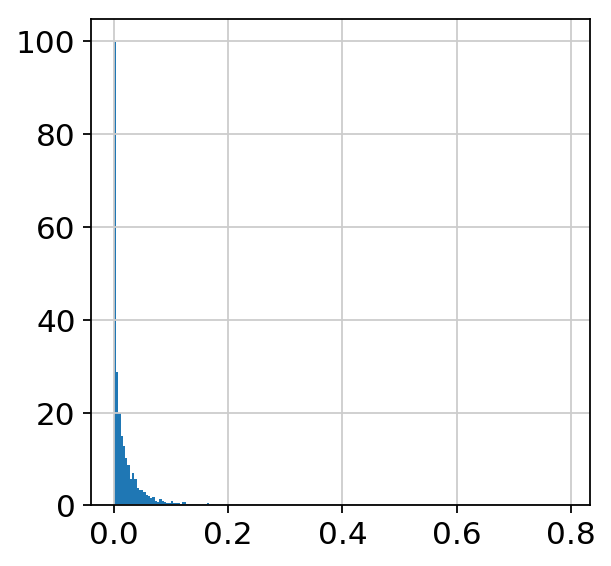

In [804]:
genelist = l20c1_m.var_names.tolist()

mito_genes_names = [gn for gn in genelist if gn.startswith('mt-')]
mito_genes = [genelist.index(gn) for gn in mito_genes_names]

l20c1_m.obs['percent_mito'] = np.ravel(np.sum(l20c1_m[:, mito_genes].X, axis=1)) / np.ravel(np.sum(l20c1_m.X, axis=1))

plt.hist(l20c1_m.obs['percent_mito'].values,bins=200,density=True);

In [805]:
l20c1_m = l20c1_m[l20c1_m.obs['percent_mito'] < 0.1].copy()

In [806]:
l20c1_m.shape

(3829, 55996)

### Dimensionality Reduction and Clustering

In [807]:
sc.pp.log1p(l20c1_m)
sc.pp.normalize_per_cell(l20c1_m, counts_per_cell_after=1e6)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [808]:
l20c1_m_unscaled = l20c1_m.copy()

In [809]:
sc.pp.scale(l20c1_m)

Note that scikit-learn's randomized PCA might not be exactly reproducible across different computational platforms. For exact reproducibility, choose `svd_solver='arpack'.` This will likely become the Scanpy default in the future.
computing PCA with n_comps = 100
    finished (0:00:07)


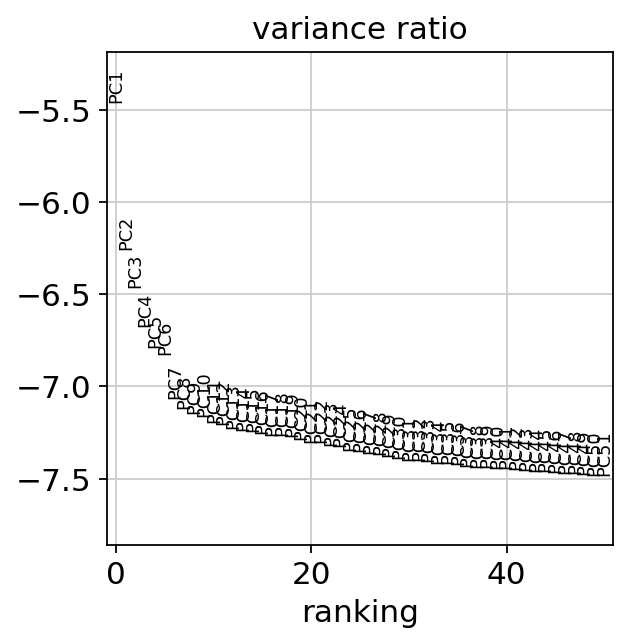

In [810]:
warnings.filterwarnings('ignore')
sc.pp.pca(l20c1_m,n_comps=100)
sc.pl.pca_variance_ratio(l20c1_m,log=True, n_pcs=50)
warnings.filterwarnings('default')

In [811]:
warnings.filterwarnings('ignore')
sc.pp.neighbors(l20c1_m,n_neighbors=15,n_pcs=15) # using all available embeddings, numba warning outlined here is not to be of concern: https://github.com/lmcinnes/umap/issues/252
warnings.filterwarnings('default')

computing neighbors
    using 'X_pca' with n_pcs = 15
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)


In [812]:
sc.tl.umap(l20c1_m)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


In [813]:
sc.tl.leiden(l20c1_m,resolution=0.88)

running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


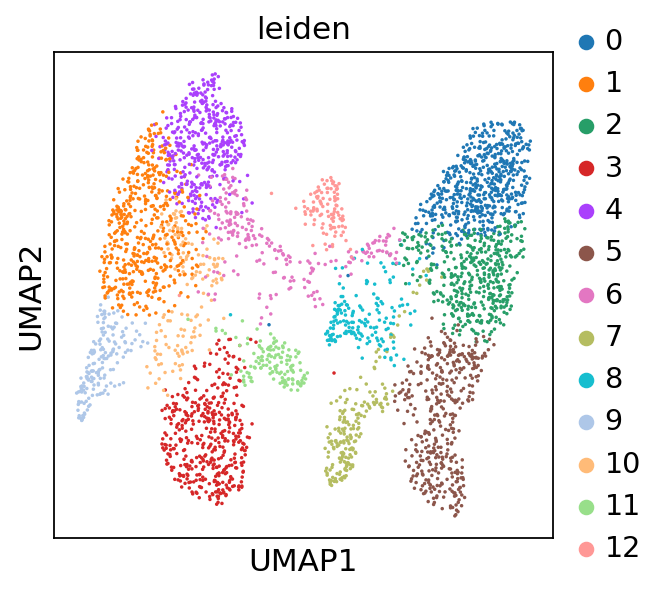

In [814]:
sc.pl.umap(l20c1_m,color=['leiden'], size=10)

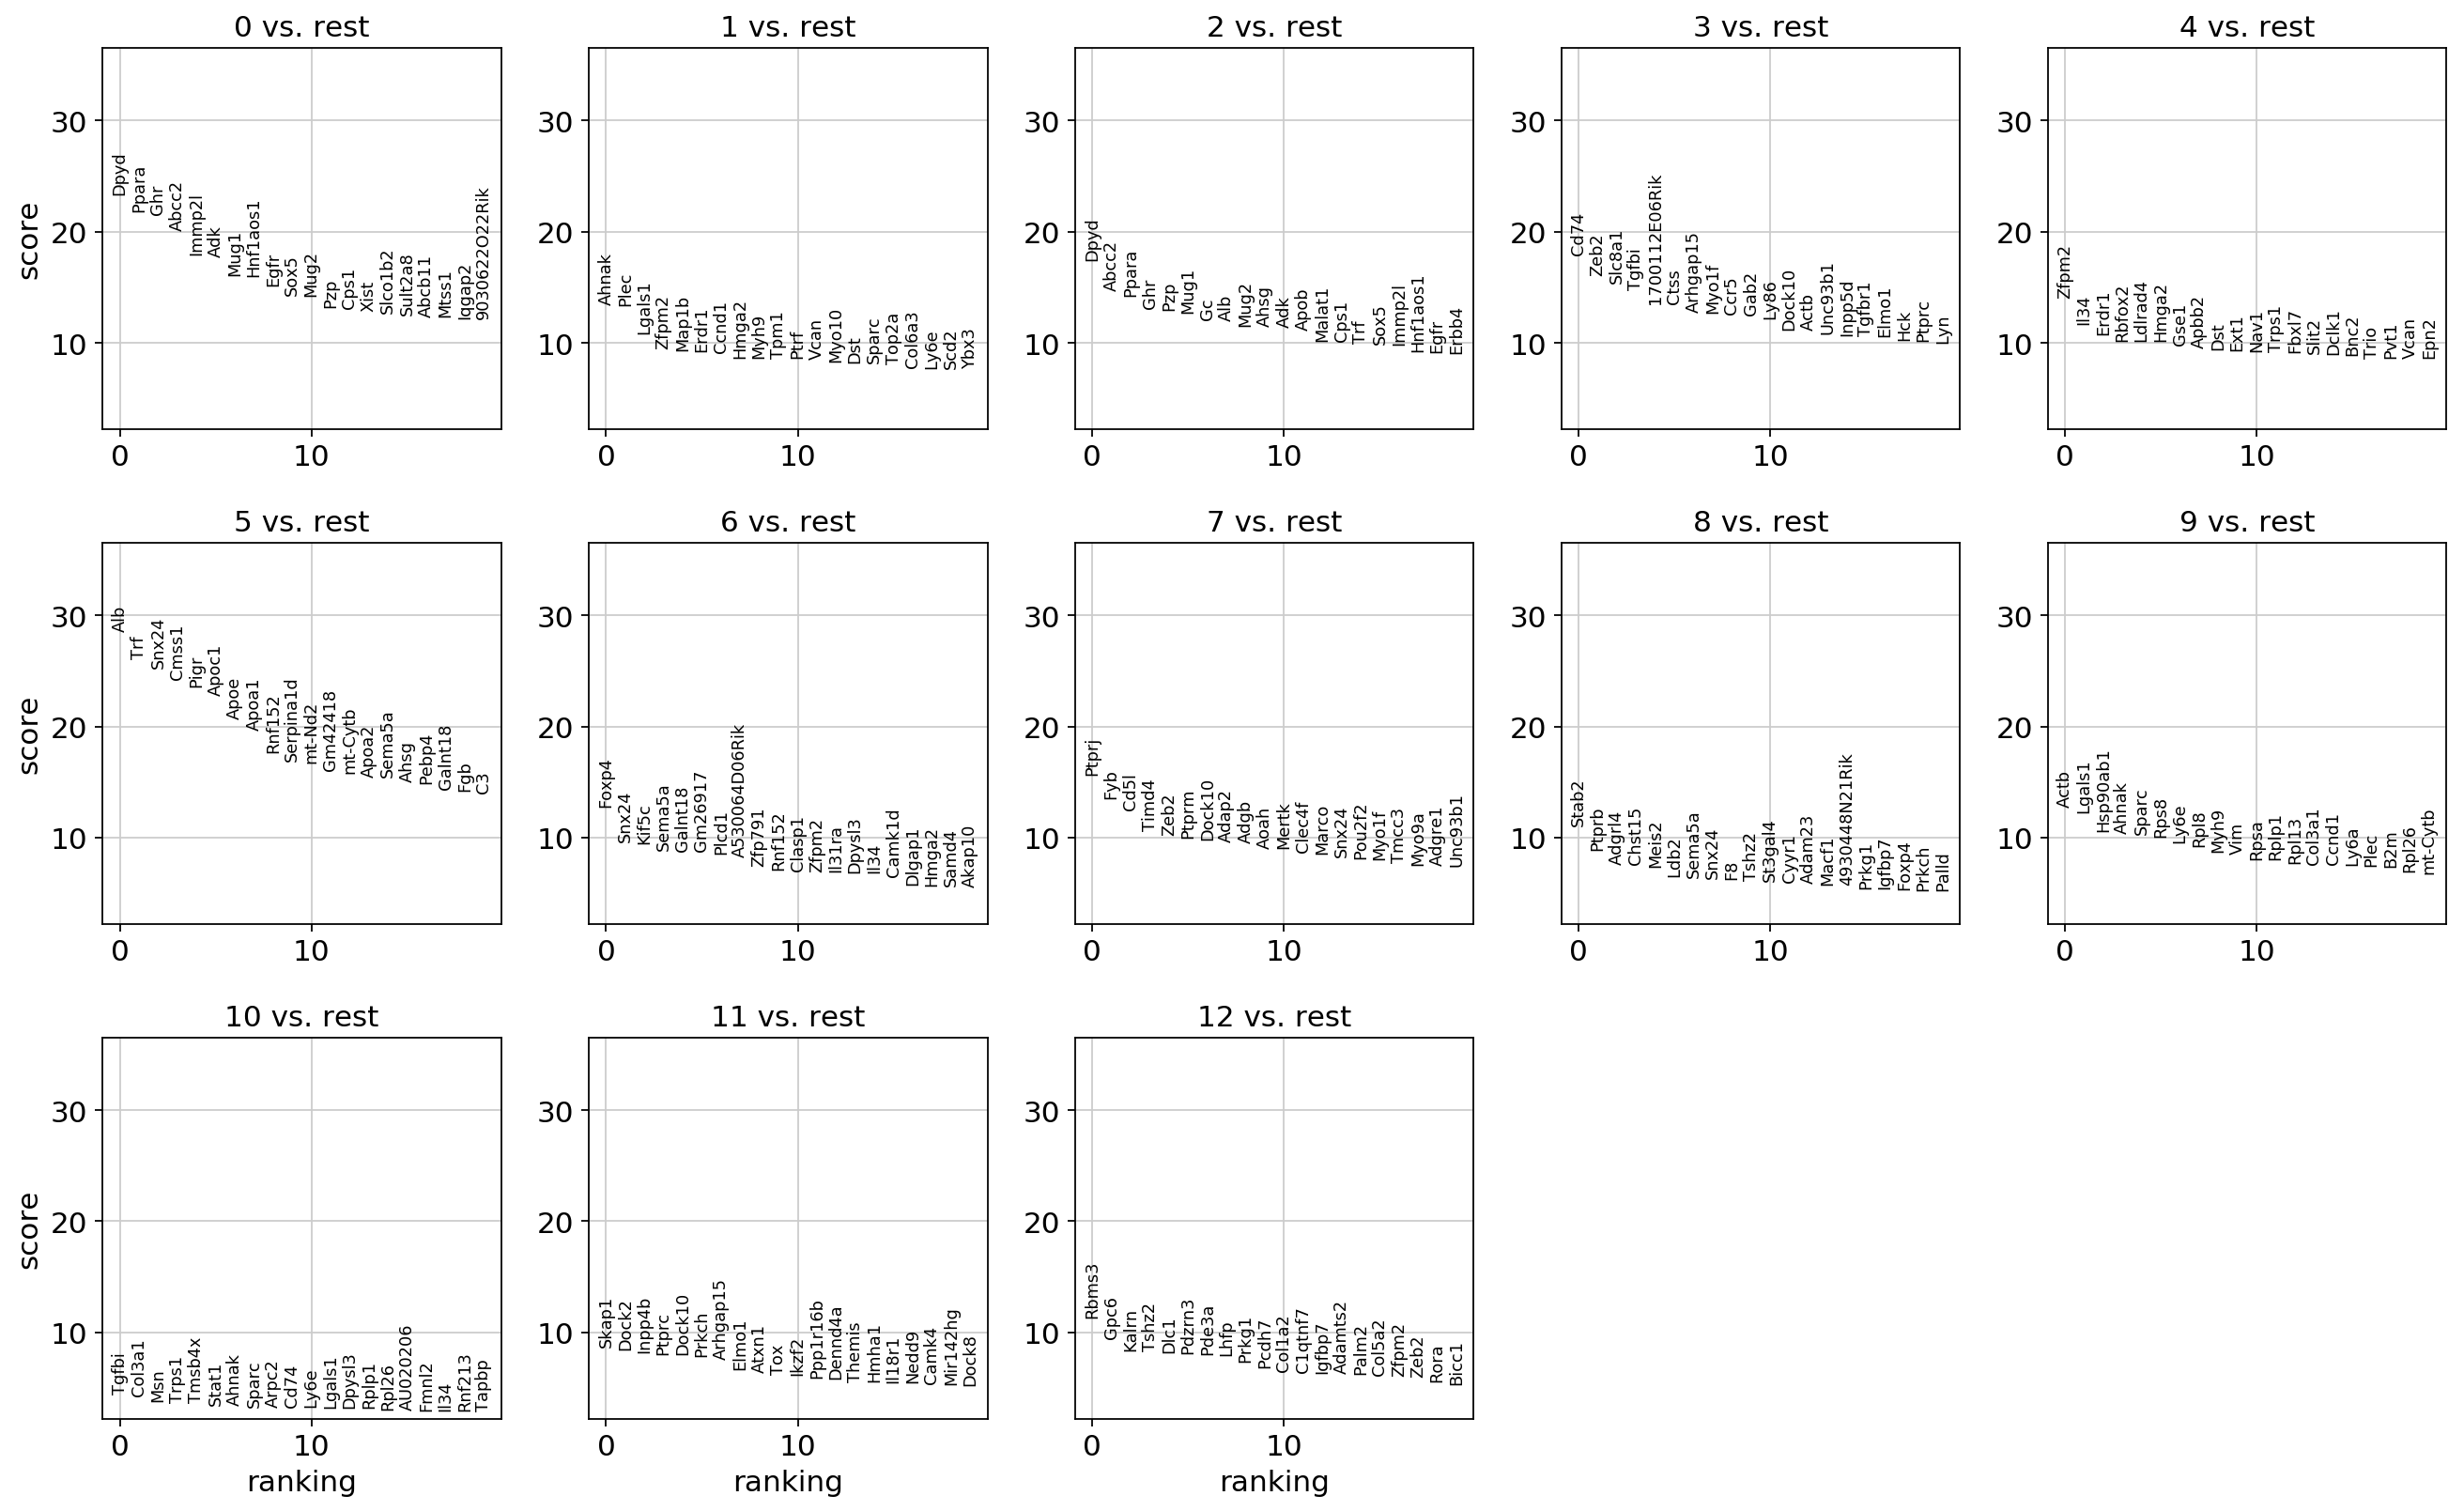

In [815]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(l20c1_m, groupby='leiden')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(l20c1_m, ncols=5)
sc.settings.verbosity = 3

### Cell Type Correlations

Code taken from https://github.com/yelabucsf/lupus_1M_cells_clean/blob/master/figure6_flare/Figure6Flare.V6.ipynb

In [816]:
def marker_gene_expression(anndata, marker_dict, gene_symbol_key=None, partition_key='louvain_r1'):
    """A function go get mean z-score expressions of marker genes
    #
    # Inputs:
    #    anndata        - An AnnData object containing the data set and a partition
    #    marker_dict     - A dictionary with cell-type markers. The markers should be stores as anndata.var_names or
    #                   an anndata.var field with the key given by the gene_symbol_key input
    #    gene_symbol_key - The key for the anndata.var field with gene IDs or names that correspond to the marker
    #                   genes
    #    partition_key   - The key for the anndata.obs field where the cluster IDs are stored. The default is
    #                   'louvain_r1' """

    # Test inputs
    if partition_key not in anndata.obs.columns.values:
        print('KeyError: The partition key was not found in the passed AnnData object.')
        print('   Have you done the clustering? If so, please pass the cluster IDs with the AnnData object!')
        raise

    if (gene_symbol_key != None) and (gene_symbol_key not in anndata.var.columns.values):
        print('KeyError: The provided gene symbol key was not found in the passed AnnData object.')
        print('   Check that your cell type markers are given in a format that your anndata object knows!')
        raise

    if gene_symbol_key:
        gene_ids = anndata.var[gene_symbol_key]
    else:
        gene_ids = anndata.var_names

    clusters = anndata.obs[partition_key].cat.categories
    n_clust = len(clusters)
    marker_exp = pd.DataFrame(columns=clusters)
    marker_exp['cell_type'] = pd.Series({}, dtype='str')
    marker_names = []

    z_scores = sc.pp.scale(anndata, copy=True)

    i = 0
    for group in marker_dict:
        # Find the corresponding columns and get their mean expression in the cluster
        for gene in marker_dict[group]:
            ens_idx = np.in1d(gene_ids, gene) #Note there may be multiple mappings
            if np.sum(ens_idx) == 0:
                continue
            else:
                z_scores.obs[ens_idx[0]] = z_scores.X[:,ens_idx].mean(1) #works for both single and multiple mapping
                ens_idx = ens_idx[0]

            clust_marker_exp = z_scores.obs.groupby(partition_key)[ens_idx].apply(np.mean).tolist()
            clust_marker_exp.append(group)
            marker_exp.loc[i] = clust_marker_exp
            marker_names.append(gene)
            i+=1

    # Replace the rownames with informative gene symbols
    marker_exp.index = marker_names

    return(marker_exp)

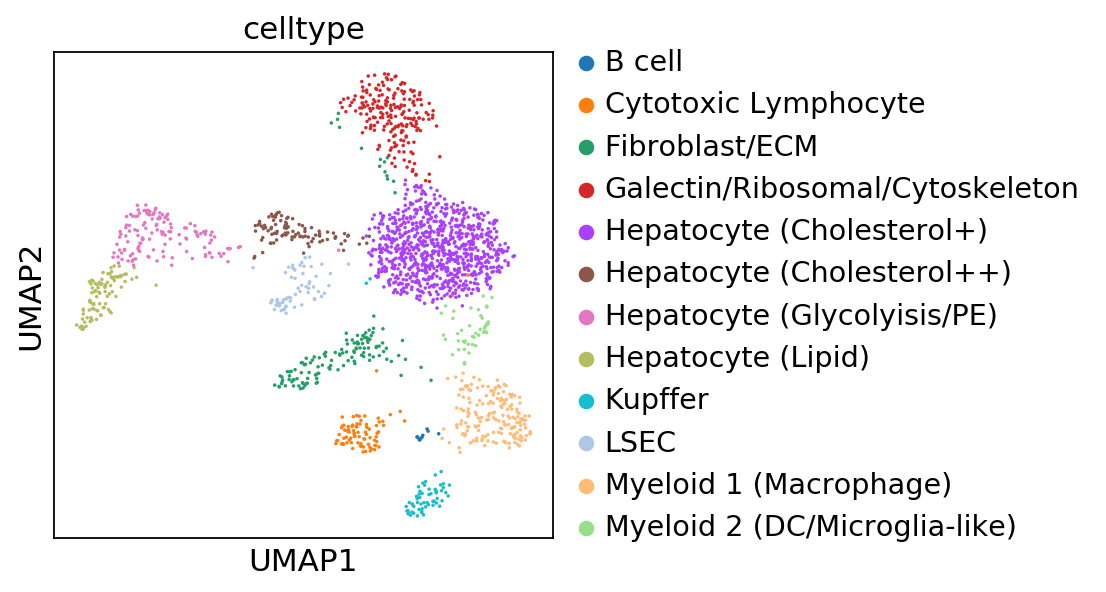

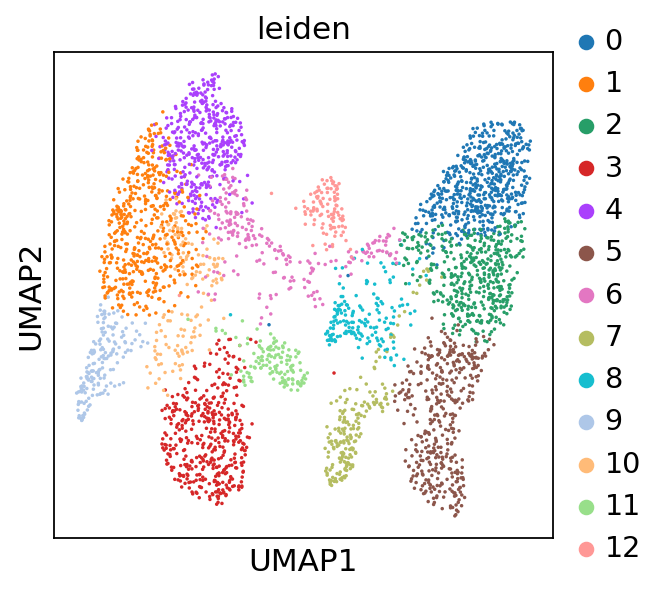

In [817]:
sc.pl.umap(liver1,color=['celltype'], size=10)
sc.pl.umap(l20c1_m,color=['leiden'], size=10)

In [818]:
num_clusts = liver1.obs['leiden'].astype(int).max() + 1
genes = np.concatenate([liver1.uns['rank_genes_groups']['names'][str(i)][:100] for i in range(num_clusts)])
genes = np.unique(genes)
genes = np.intersect1d(genes, l20c1_m.var_names.values)

In [819]:
marker_dictionary = pd.DataFrame({"all": genes})

In [821]:
liver1_unscaled.obs['celltype'] = liver1.obs['celltype'].values
l20c1_m_unscaled.obs['leiden'] = l20c1_m.obs['leiden'].values

In [822]:
marker_exp_10x = marker_gene_expression(liver1_unscaled, marker_dictionary, partition_key="celltype")

In [823]:
marker_exp_XYZeq = marker_gene_expression(l20c1_m_unscaled, marker_dictionary, partition_key="leiden")

In [824]:
exp_result = pd.concat([marker_exp_10x, marker_exp_XYZeq], axis=1, join='inner')

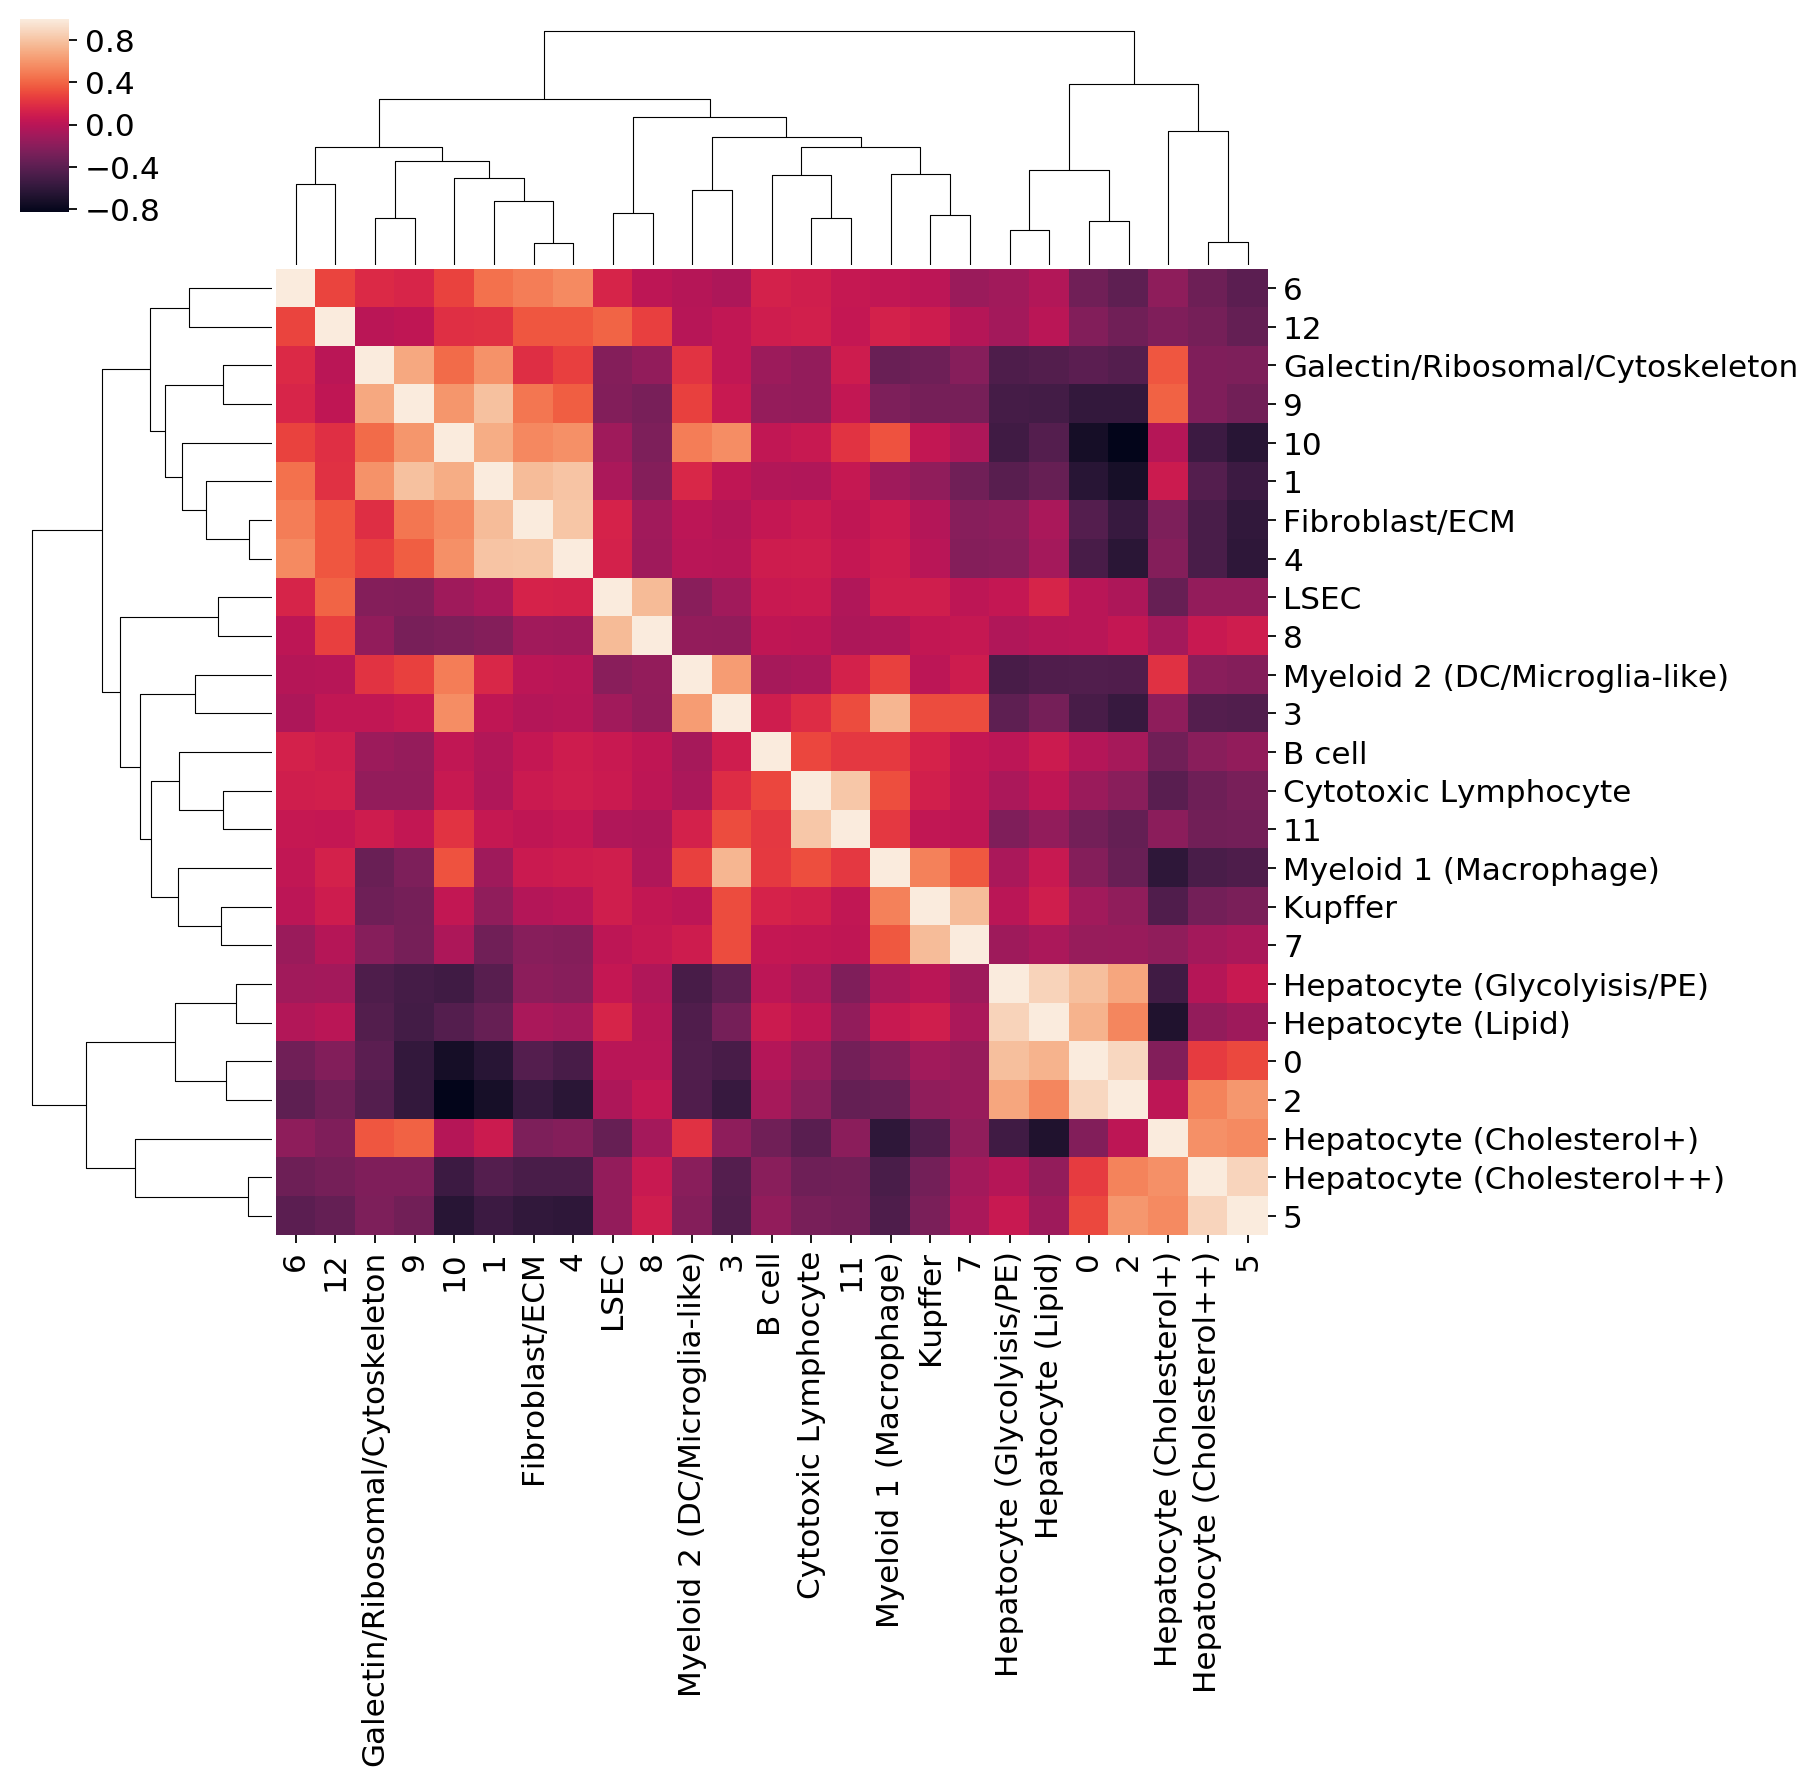

In [825]:
exp_corr = exp_result.corr()
exp_corr.style.background_gradient(cmap='coolwarm').set_precision(2)
g = sns.clustermap(exp_corr, yticklabels=True, xticklabels=True)

# Merge the Datasets

I need to combine the 10x data with L20C1. I'll merge the raw counts after filtering, and then run Harmony, followed by dimensionality reduction and clustering. 

Concatenate on the inner join of genes, and get rid of the batch key.

In [877]:
warnings.filterwarnings('ignore')
liver1_for_concat = sc.read_10x_h5(prefix + '10x/20191102/Liver1_raw_feature_bc_matrix.h5', genome='mm10')
sc.utils.view_to_actual(liver1)
liver1_for_concat.var_names_make_unique()
warnings.filterwarnings('default')

reading /data/xyzeq/10x/20191102/Liver1_raw_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:07)


In [878]:
l20c1_for_concat = sc.read_h5ad(l20c1_path)

In [879]:
print(liver1_for_concat.shape)
print(l20c1_for_concat.shape)

(6794880, 28692)
(26436, 121472)


In [880]:
liver1_for_concat = liver1_for_concat[liver1.obs_names].copy()

In [881]:
l20c1_for_concat = l20c1_for_concat[l20c1_m.obs_names].copy()

l20c1_for_concat = l20c1_for_concat[:,[i for i in l20c1_for_concat.var_names if i.startswith('mm10_')]].copy()
l20c1_for_concat.var_names
l20c1_for_concat.var_names = [i[5:] for i in l20c1_for_concat.var_names]

In [886]:
print(liver1_for_concat.shape)
print(l20c1_for_concat.shape)

(1949, 28692)
(3829, 55996)


In [1000]:
np.random.seed(0)
random_indices = np.random.choice(range(l20c1_for_concat.shape[0]), liver1_for_concat.shape[0], replace=False)

In [1001]:
l20c1_for_concat = l20c1_for_concat[random_indices].copy()

In [1002]:
concat = liver1_for_concat.concatenate(l20c1_for_concat, join='inner')

In [1003]:
concat.shape

(3898, 27998)

In [1004]:
concat.obs.index = [i[:-2] for i in concat.obs.index]

Write to file so I can run Harmony in a separate notebook.

In [1005]:
concat.write_h5ad(prefix + '10x/20191102/concat.liver1.L20C1.h5ad')

... storing 'feature_types-0' as categorical
... storing 'genome-0' as categorical


Normalize per cell and log1p. I do this in Harmony separately using Seurat.

In [1006]:
sc.pp.normalize_per_cell(concat, counts_per_cell_after=1e6)
sc.pp.log1p(concat)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


Read back in the embeddings from Harmony.

In [1007]:
harmony = pd.read_csv(prefix + '10x/20191102/harmony.embeddings.liver1.L20C1.default.hvg.csv')
concat.obsm['X_pca'] = harmony.values

Remap the batches to make them more descriptive.

In [1008]:
concat.obs['batch'] = concat.obs['batch'].map({'0': '10x', '1':'XYZeq'})

In [1009]:
warnings.filterwarnings('ignore')
sc.pp.neighbors(concat,n_neighbors=15,n_pcs=50) # using all available embeddings, numba warning outlined here is not to be of concern: https://github.com/lmcinnes/umap/issues/252
warnings.filterwarnings('default')

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)


In [1010]:
sc.tl.umap(concat)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)


In [1011]:
sc.tl.leiden(concat,resolution=0.5)

running Leiden clustering
    finished: found 9 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


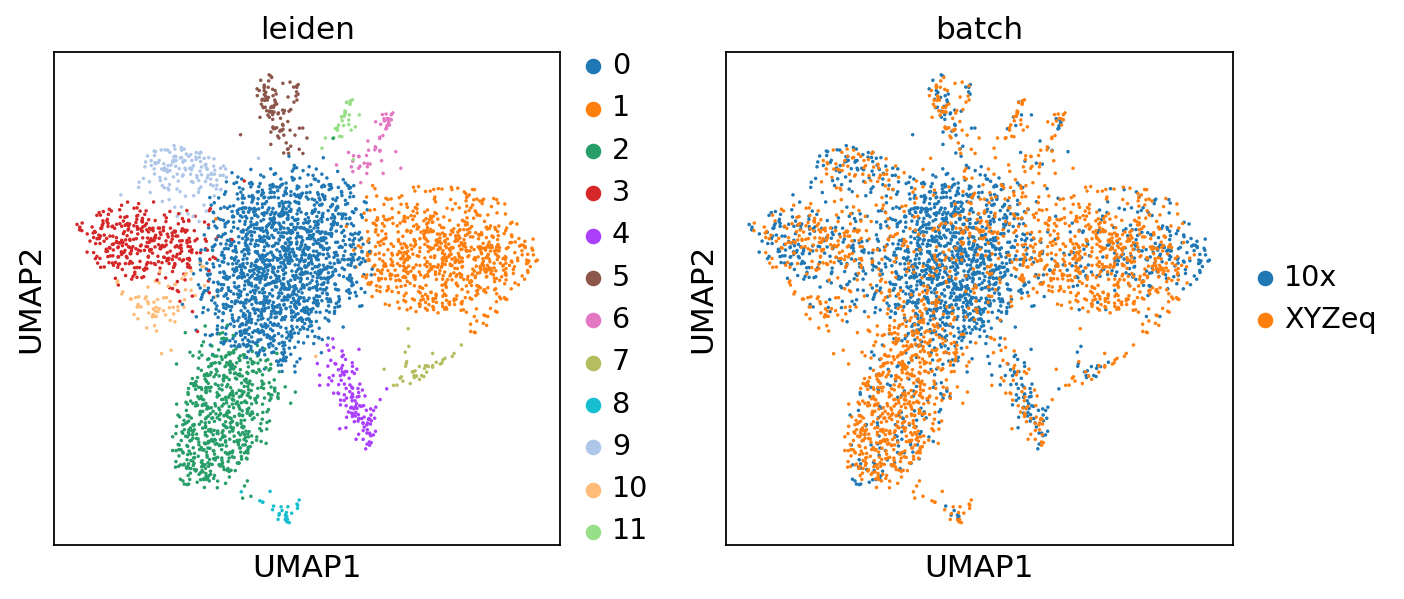

In [1044]:
sc.pl.umap(concat,color=['leiden', 'batch'], size=10, palette=sc.pl.palettes.default_20)

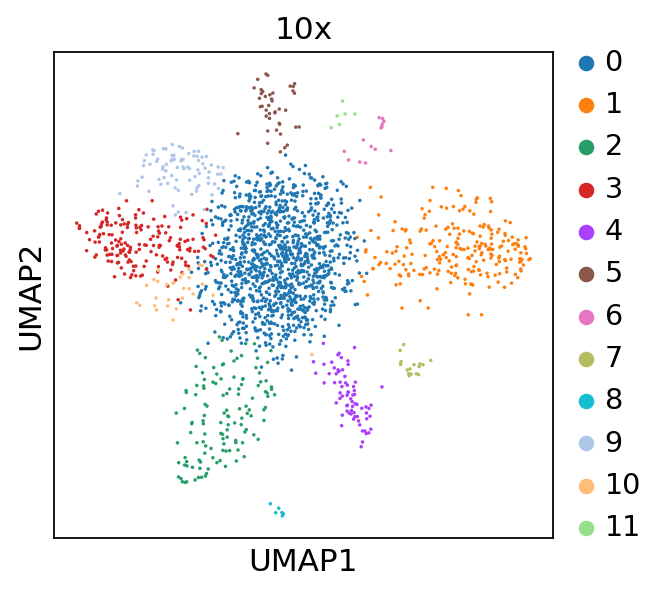

In [1050]:
sc.pl.umap(concat[concat.obs['batch'] == '10x'],color=['leiden'], size=10, palette=sc.pl.palettes.default_20, title='10x')

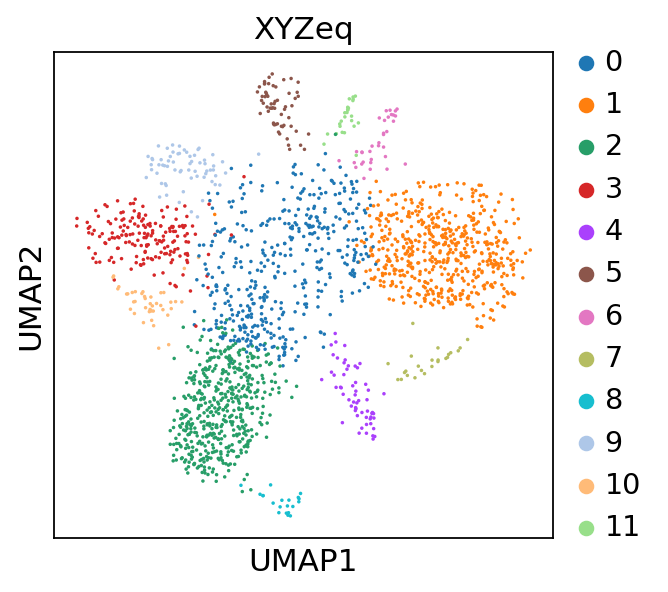

In [1049]:
sc.pl.umap(concat[concat.obs['batch'] == 'XYZeq'],color=['leiden'], size=10, palette=sc.pl.palettes.default_20, title='XYZeq')

In [1024]:
sub_adatas = dict() # put the new subsetted adata objects in a dictionary of adatas
for clust in [3, 6]:
    sub_adatas[str(clust)] = concat[concat.obs['leiden'] == str(clust)].copy()

running Leiden clustering
    finished: found 3 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


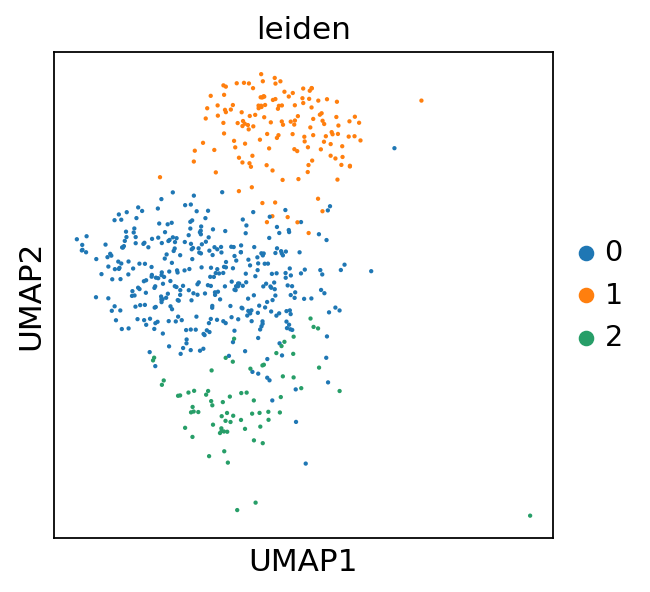

In [1025]:
sc.tl.leiden(sub_adatas['3'], resolution=0.4) # subcluster them using Leiden
sc.pl.umap(sub_adatas['3'], color='leiden', size=15)

running Leiden clustering
    finished: found 2 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


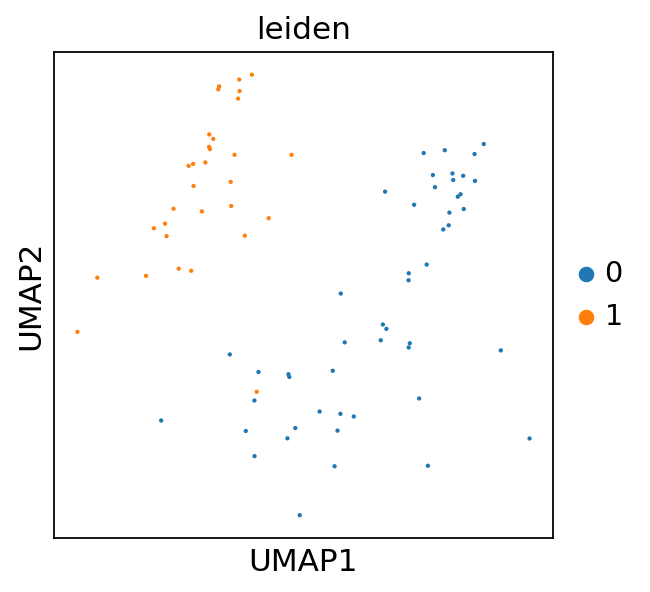

In [1026]:
sc.tl.leiden(sub_adatas['6'], resolution=0.4) # subcluster them using Leiden
sc.pl.umap(sub_adatas['6'], color='leiden', size=15)

Map them back to the clusters on the original adata

In [1027]:
def sub_cluster_mapper(adata, sub_adatas):
    '''
    This takes in the adata object and inserts a new leiden column in the `.obs`. 
    
    This function is really convoluted and there's probably a better, simpler way to do it,
    but it should theoretically work for any number of subclusters
    '''
    # ideally you'd make a copy of the adata object here, so we don't have to change the original
    # this would be in case we want to run it multiple times, perhaps the resolutions we put in didn't subset the clusters like we had hoped
    # and we need to run multiple times to adjust the resolution slightly
    
    # this block is to figure out that there are two new subclusters and they should be named 8, 9
    total_new_clusts = 0
    old_clusts = sub_adatas.keys()
    for sub_adata in sub_adatas:
        total_new_clusts += sub_adatas[sub_adata].obs['leiden'].astype(int).unique().max() + 1
    total_added_clusts = total_new_clusts - len(sub_adatas)
    new_clust_names_start = max(adata.obs['leiden'].astype(int))+1
    new_added_clust_names = [str(i) for i in range(new_clust_names_start,
                                                   new_clust_names_start + total_added_clusts)]
    
    # this block is to build a new list of leiden clusters from the old one 
    new_leiden = list()
    leiden_col = adata.obs['leiden'].copy()

    # this builds the new leiden cluster list, now adding a .1, .2, etc. to each new cluster
    for obs in leiden_col.index:
        clust_name = leiden_col.loc[obs]
        if clust_name not in old_clusts or sub_adatas[clust_name].obs.loc[obs, 'leiden'] == '0':
            new_leiden.append(clust_name)
        else:
            new_leiden.append(clust_name + '.%s' % sub_adatas[clust_name].obs.loc[obs,'leiden'])

    # this renames the .1, .2, etc clusters to the new, better names I came up with above (8 and 9)
    new_leiden = pd.Series(new_leiden, index=adata.obs_names)
    added_clusts = np.setdiff1d(new_leiden,adata.obs['leiden'])
    new_leiden.replace(dict(zip(added_clusts, new_added_clust_names)), inplace=True)
    
    # replace the old leiden column
    adata.obs['leiden'] = new_leiden.astype(int) # need to do astype(int) to reorder them to the numerical order, then make them a cat
    adata.obs['leiden'] = adata.obs['leiden'].astype(str)
#     adata.obs['leiden'] = adata.obs['leiden'].astype('category') # don't do this yet, just let it store as category when you plot the umap, otherwise it won't color-code in correct order
    
    return adata

In [1028]:
concat_sub = sub_cluster_mapper(concat, sub_adatas)

... storing 'leiden' as categorical


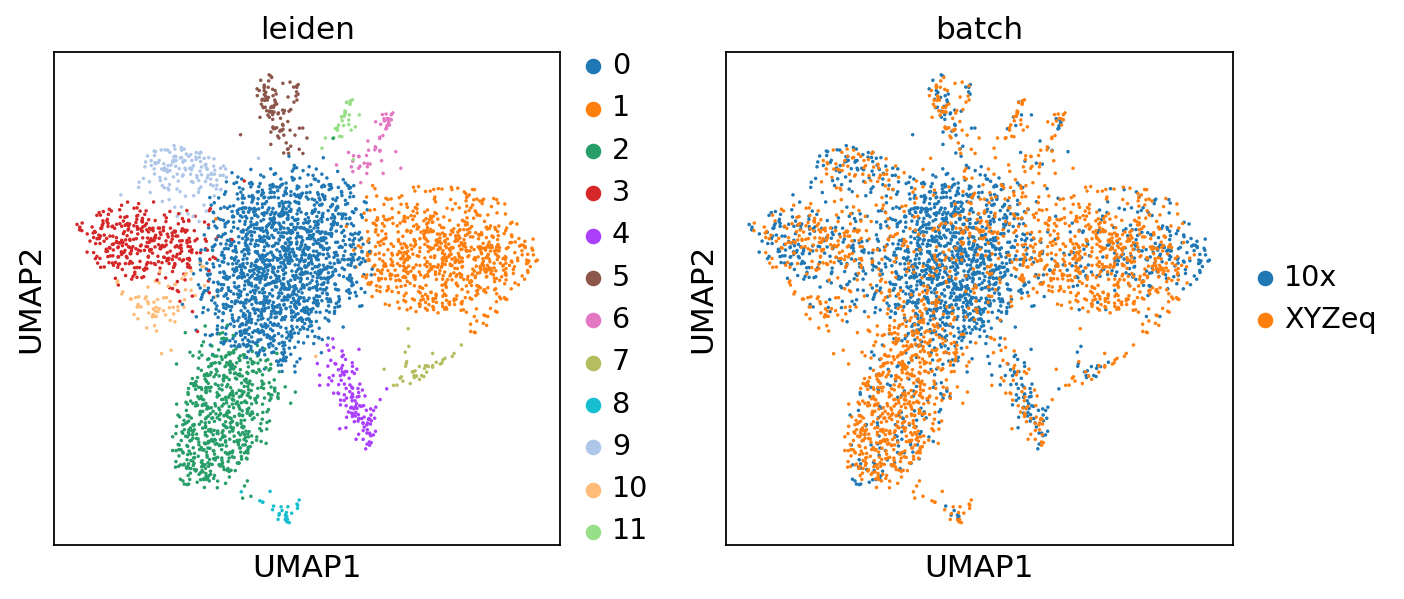

In [1029]:
sc.pl.umap(concat_sub,color=['leiden', 'batch'], size=10, ncols=5)

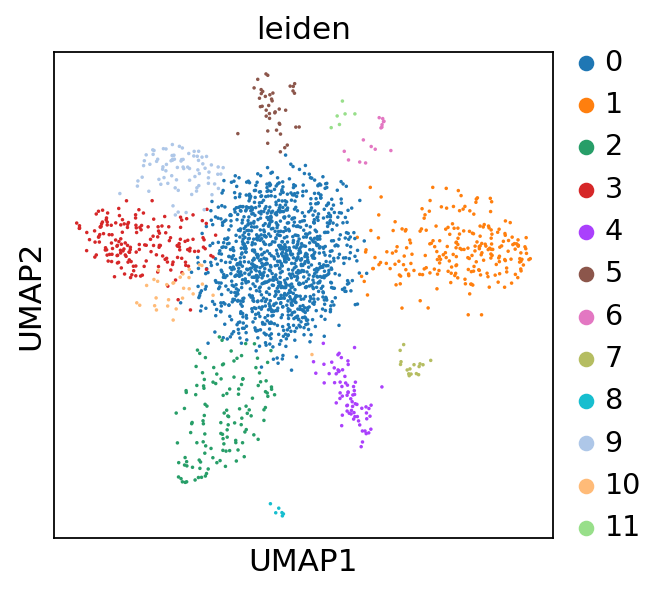

In [1030]:
sc.pl.umap(concat[concat.obs['batch'] == '10x'],color=['leiden'], size=10, palette=sc.pl.palettes.default_20)

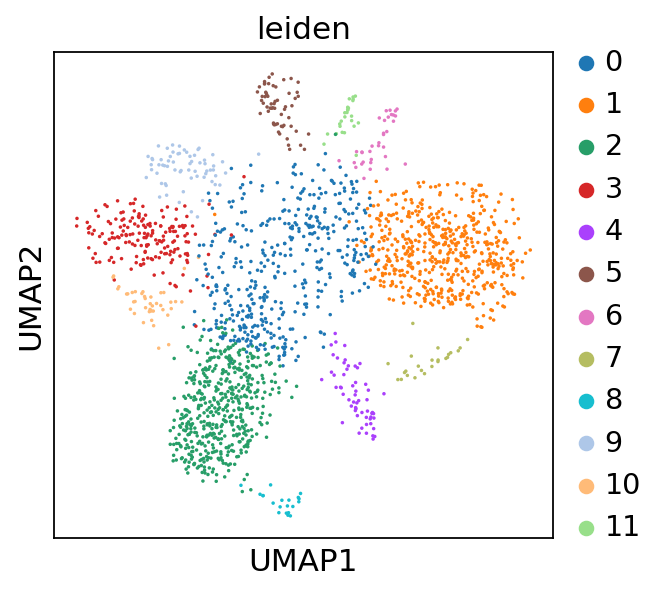

In [1031]:
sc.pl.umap(concat[concat.obs['batch'] == 'XYZeq'],color=['leiden'], size=10, palette=sc.pl.palettes.default_20)

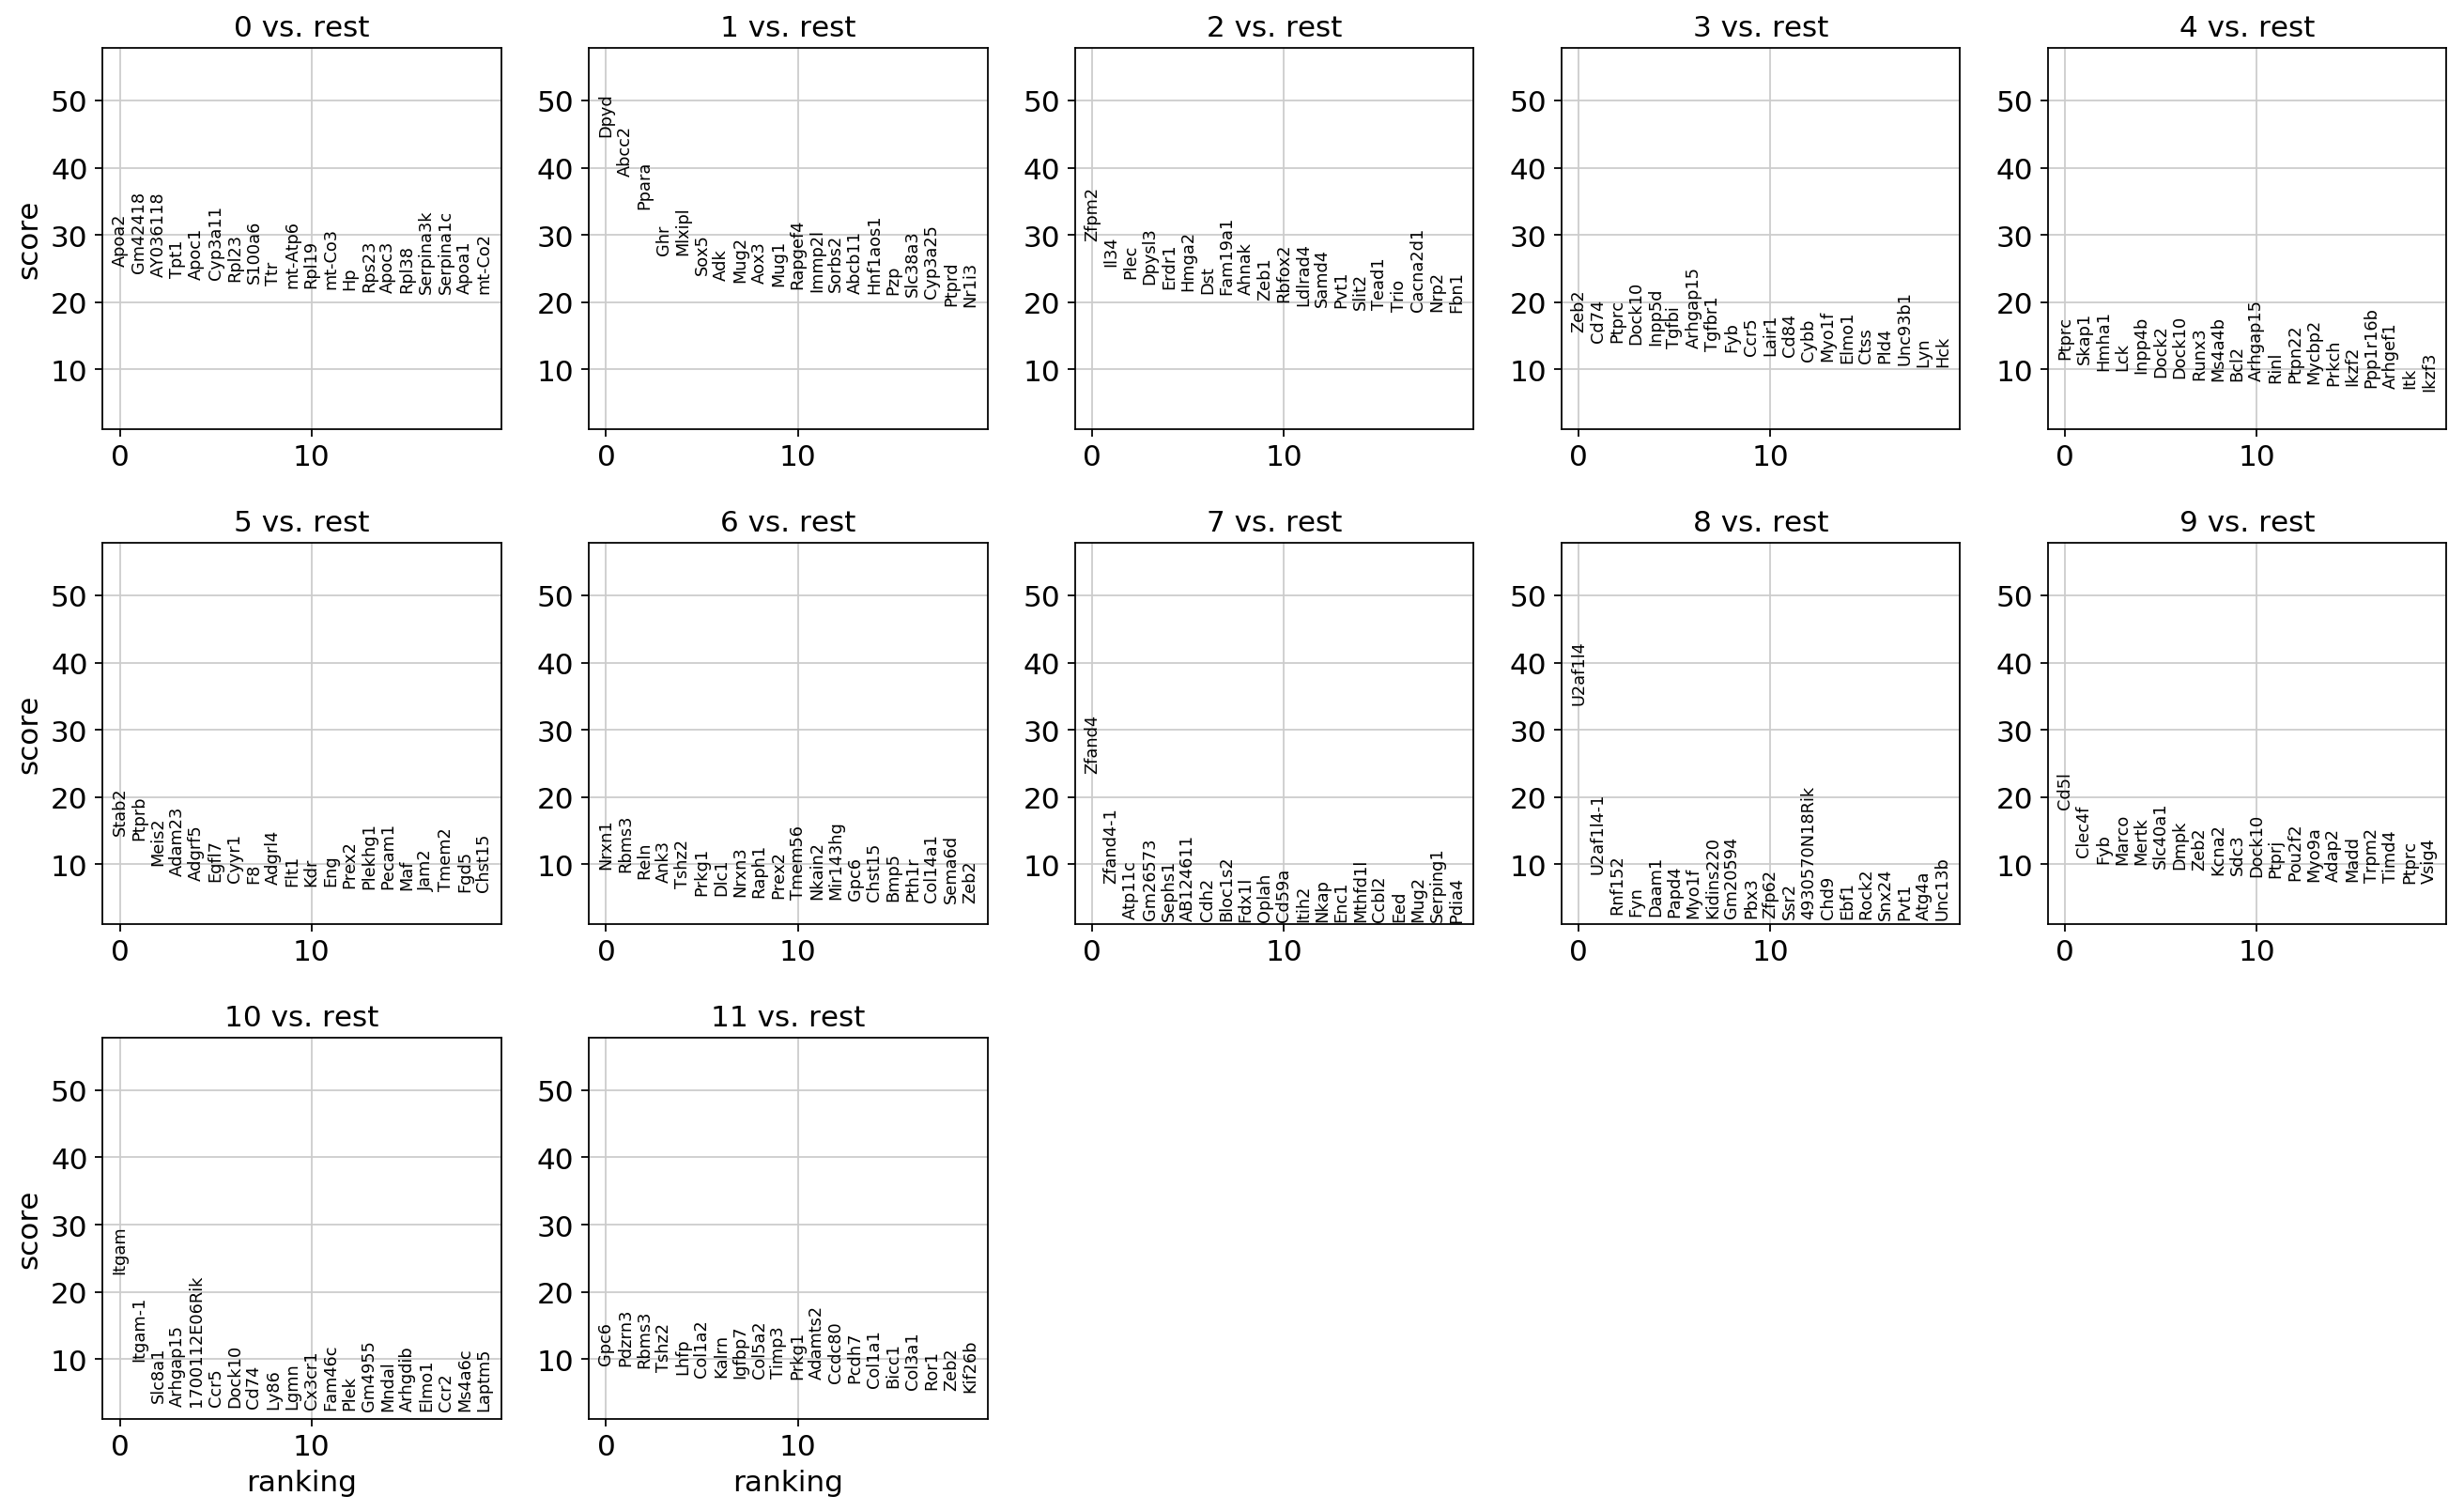

In [1032]:
sc.settings.verbosity = 0 
warnings.filterwarnings('ignore')
sc.tl.rank_genes_groups(concat_sub,groupby='leiden')
warnings.filterwarnings('default')
sc.pl.rank_genes_groups(concat_sub, ncols=5)
sc.settings.verbosity = 3

### Correlate proportion in each Leiden cluster

In [1033]:
clust_counts = list()
clusts = range(len(concat.obs['leiden'].unique()))
for leiden in clusts:
    batches = concat[concat.obs['leiden'] == str(leiden)].obs['batch'].values
    vals, counts = np.unique(batches, return_counts=True)
    clust_counts.append(counts)

In [1034]:
vals, batch_counts = np.unique(concat.obs['batch'].values, return_counts=True)

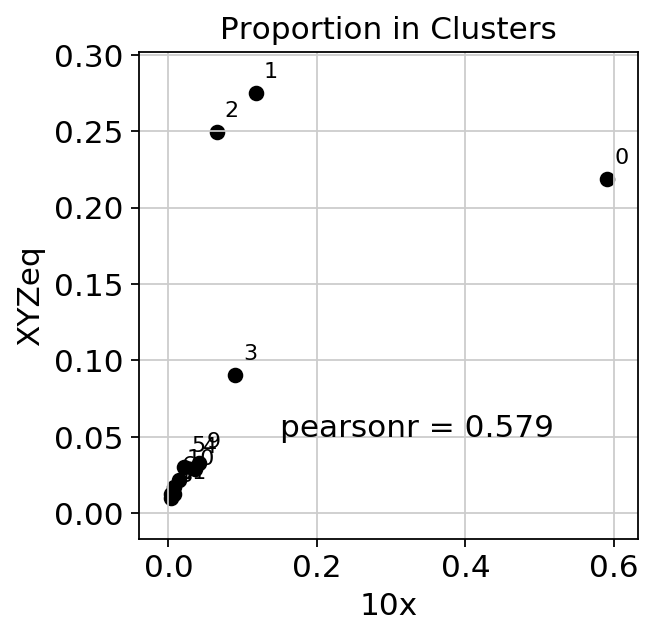

In [1051]:
x = [i[0]/batch_counts[0] for i in clust_counts]
y = [i[1]/batch_counts[1] for i in clust_counts]
n = clusts

plt.scatter(x, y, color='k');
plt.title('Proportion in Clusters')
plt.xlabel('%s' % vals[0])
plt.ylabel('%s' % vals[1])
# plt.xlim(0,0.7)
# plt.xticks(np.arange(0, 0.35, 0.05))
# plt.ylim(0,0.7)
ax = plt.gca()
for i, txt in enumerate(n):
    ax.annotate(txt, (x[i]+0.01, y[i]+0.01), size=10)

# The difference between correlation and coefficient of determination
# They can correlate, but that's not what I want to see. I want to see how well they fit the model that the proportions should be identical, x = y
# is the r2_score() command right then?

r = pearsonr(x,y)[0]
# r2 = r2_score(y_true=y, y_pred=x)

plt.text(0.15, 0.05, 'pearsonr = ' + str(r)[:5]);
# plt.text(0.15, 0.05, 'r^2 = ' + str(r2)[:5]);


In [968]:
x[0], y[0]

(0.6080041046690611, 0.28884826325411334)